In [22]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/gdrive


In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [24]:
from datetime import datetime, timedelta

In [25]:
#read the ground truth and the prediction data
labels_df = pd.read_excel('/content/gdrive/MyDrive/test_17May/Labels 05-17-2024_modified.xlsx')
predictions_df_front = pd.read_csv('/content/gdrive/MyDrive/test_17May/cow_behavior_front_20240517064400.csv')
predictions_df_top = pd.read_csv('/content/gdrive/MyDrive/test_17May/cow_behavior_top_IoU_20240517064400_0.8_0.5.csv')

In [26]:
labels_df.head()

,Date,Time,cow-a (black),cow-b (white-pattern),cow-c (black-pattern)
0,17-05-2024,06.44.38,stand,lay,stand
1,17-05-2024,06.44.47,ride,stand,stand
2,17-05-2024,06.44.50,stand,stand,stand
3,17-05-2024,06.45.15,stand,ride,stand
4,17-05-2024,06.45.19,stand,stand,stand


In [27]:
labels_df['cow-b (white-pattern)'].value_counts()

,count
cow-b (white-pattern),
stand,552
eat,22
lay,13
ride,10
propping,8
drink,3


In [28]:
predictions_df_front.head()

,Date,Time,cow-a (black),cow-b (white-pattern),cow-c (black-pattern)
0,17-05-2024,06.44.00,stand,stand,stand
1,17-05-2024,06.44.01,stand,stand,stand
2,17-05-2024,06.44.02,stand,stand,stand
3,17-05-2024,06.44.03,stand,stand,stand
4,17-05-2024,06.44.04,stand,stand,stand


In [29]:
predictions_df_front['cow-b (white-pattern)'].value_counts()

,count
cow-b (white-pattern),
stand,49287
eat,9037
propping,1904
drink,1814
laying,67
ride,51


In [30]:
#Change the laying to lay for consistency
predictions_df_front['cow-a (black)'] = predictions_df_front['cow-a (black)'].replace('laying', 'lay')
predictions_df_front['cow-b (white-pattern)'] = predictions_df_front['cow-b (white-pattern)'].replace('laying', 'lay')
predictions_df_front['cow-c (black-pattern)'] = predictions_df_front['cow-c (black-pattern)'].replace('laying', 'lay')

In [31]:
predictions_df_top.head()

,Date,Time,cow-a (black),cow-a (black) (detection confidence),cow-a (black) (Activity confidence),cow-a (black) (iou),cow-b (white-pattern),cow-b (white-pattern) (detection confidence),cow-b (white-pattern) (Activity confidence),cow-b (white-pattern) (iou),cow-c (black-pattern),cow-c (black-pattern) (detection confidence),cow-c (black-pattern) (Activity confidence),cow-c (black-pattern) (iou)
0,17-05-2024,06.44.00,lay,0.519999,0.658463,0.569039,lay,0.822466,0.795403,0.958753,ride,0.634553,0.781090,0.750654
1,17-05-2024,06.44.01,lay,0.000000,0.604997,-1.000000,lay,0.813774,0.805077,0.945794,lay,0.633899,0.805077,0.763635
2,17-05-2024,06.44.02,lay,0.693706,0.704566,0.602244,lay,0.792417,0.802808,0.947484,lay,0.672932,0.802808,0.780180
3,17-05-2024,06.44.03,lay,0.817344,0.721923,0.766595,lay,0.787689,0.802556,0.949350,ride,0.813474,0.778557,0.666071
4,17-05-2024,06.44.04,lay,0.813699,0.686504,0.767713,lay,0.732089,0.805036,0.909425,ride,0.792300,0.774222,0.773496


In [32]:
predictions_df_top['cow-b (white-pattern)'].value_counts()

,count
cow-b (white-pattern),
stand,21763
propping,16802
eat,8998
ride,6631
lay,5099
drinking,2869


In [33]:
#Change the drinking to drink
predictions_df_top['cow-a (black)'] = predictions_df_top['cow-a (black)'].replace('drinking', 'drink')
predictions_df_top['cow-b (white-pattern)'] = predictions_df_top['cow-b (white-pattern)'].replace('drinking', 'drink')
predictions_df_top['cow-c (black-pattern)'] = predictions_df_top['cow-c (black-pattern)'].replace('drinking', 'drink')

predictions_df_top['cow-a (black)'] = predictions_df_top['cow-a (black)'].replace('stand near fence', 'stand')
predictions_df_top['cow-b (white-pattern)'] = predictions_df_top['cow-b (white-pattern)'].replace('stand near fence', 'stand')
predictions_df_top['cow-c (black-pattern)'] = predictions_df_top['cow-c (black-pattern)'].replace('stand near fence', 'stand')

In [34]:
# Convert 'Time' columns to datetime objects
labels_df['Time'] = pd.to_datetime(labels_df['Time'], format='%H.%M.%S', errors='coerce')
predictions_df_top['Time'] = pd.to_datetime(predictions_df_top['Time'], format='%H.%M.%S', errors='coerce')
predictions_df_front['Time'] = pd.to_datetime(predictions_df_front['Time'], format='%H.%M.%S', errors='coerce')

# Handle missing 'Time' values
labels_df = labels_df.dropna(subset=['Time'])
predictions_df_top = predictions_df_top.dropna(subset=['Time'])
predictions_df_front = predictions_df_front.dropna(subset=['Time'])

# Filter data to only include times from 06:44:00 onward and up to 23:59:59
start_time = pd.to_datetime('06:44:00', format='%H:%M:%S')
end_time = pd.to_datetime('23:59:59', format='%H:%M:%S')

labels_df = labels_df[(labels_df['Time'] >= start_time) & (labels_df['Time'] <= end_time)]
predictions_df_top = predictions_df_top[(predictions_df_top['Time'] >= start_time) & (predictions_df_top['Time'] <= end_time)]
predictions_df_front = predictions_df_front[(predictions_df_front['Time'] >= start_time) & (predictions_df_front['Time'] <= end_time)]

# Define label columns
label_columns = ['cow-a (black)', 'cow-b (white-pattern)', 'cow-c (black-pattern)']

# Normalize string values for all relevant columns
for col in label_columns:
    labels_df[col] = labels_df[col].str.strip().str.lower()
    predictions_df_top[col] = predictions_df_top[col].str.strip().str.lower()
    predictions_df_front[col] = predictions_df_front[col].str.strip().str.lower()

# Combine predictions from top and front views (giving top priority to top view predictions if overlapping)
predictions_df = pd.merge_asof(
    predictions_df_top.sort_values('Time'),
    predictions_df_front.sort_values('Time'),
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta(seconds=0.5),  # optionally increase this if time doesn't exactly align
    suffixes=('_top', '_front')
)

time_tolerance = pd.Timedelta(seconds=2)
merged_df = pd.merge_asof(
    labels_df.sort_values('Time'),
    predictions_df.sort_values('Time'),
    on='Time',
    tolerance=time_tolerance,
    direction='nearest',
    suffixes=('_true', '_pred')
)


In [35]:
predictions_df

,Date_top,Time,cow-a (black)_top,cow-a (black) (detection confidence),cow-a (black) (Activity confidence),cow-a (black) (iou),cow-b (white-pattern)_top,cow-b (white-pattern) (detection confidence),cow-b (white-pattern) (Activity confidence),cow-b (white-pattern) (iou),cow-c (black-pattern)_top,cow-c (black-pattern) (detection confidence),cow-c (black-pattern) (Activity confidence),cow-c (black-pattern) (iou),Date_front,cow-a (black)_front,cow-b (white-pattern)_front,cow-c (black-pattern)_front
0,17-05-2024,1900-01-01 06:44:00,lay,0.519999,0.658463,0.569039,lay,0.822466,0.795403,0.958753,ride,0.634553,0.781090,0.750654,17-05-2024,stand,stand,stand
1,17-05-2024,1900-01-01 06:44:01,lay,0.000000,0.604997,-1.000000,lay,0.813774,0.805077,0.945794,lay,0.633899,0.805077,0.763635,17-05-2024,stand,stand,stand
2,17-05-2024,1900-01-01 06:44:02,lay,0.693706,0.704566,0.602244,lay,0.792417,0.802808,0.947484,lay,0.672932,0.802808,0.780180,17-05-2024,stand,stand,stand
3,17-05-2024,1900-01-01 06:44:03,lay,0.817344,0.721923,0.766595,lay,0.787689,0.802556,0.949350,ride,0.813474,0.778557,0.666071,17-05-2024,stand,stand,stand
4,17-05-2024,1900-01-01 06:44:04,lay,0.813699,0.686504,0.767713,lay,0.732089,0.805036,0.909425,ride,0.792300,0.774222,0.773496,17-05-2024,stand,stand,stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62155,17-05-2024,1900-01-01 23:59:55,stand,0.000000,0.507482,-1.000000,propping,0.881628,0.749121,0.813266,propping,0.000000,0.786485,-1.000000,17-05-2024,stand,stand,stand
62156,17-05-2024,1900-01-01 23:59:56,stand,0.000000,0.507482,-1.000000,propping,0.803457,0.706863,0.857345,propping,0.000000,0.786485,-1.000000,17-05-2024,stand,stand,stand
62157,17-05-2024,1900-01-01 23:59:57,stand,0.000000,0.507482,-1.000000,propping,0.903562,0.740633,0.905718,propping,0.580333,0.786485,0.000000,17-05-2024,stand,stand,stand
62158,17-05-2024,1900-01-01 23:59:58,stand,0.000000,0.507482,-1.000000,propping,0.811097,0.796110,0.871029,propping,0.000000,0.786485,-1.000000,17-05-2024,stand,stand,stand


In [36]:
merged_df.head()

,Date,Time,cow-a (black),cow-b (white-pattern),cow-c (black-pattern),Date_top,cow-a (black)_top,cow-a (black) (detection confidence),cow-a (black) (Activity confidence),cow-a (black) (iou),...,cow-b (white-pattern) (Activity confidence),cow-b (white-pattern) (iou),cow-c (black-pattern)_top,cow-c (black-pattern) (detection confidence),cow-c (black-pattern) (Activity confidence),cow-c (black-pattern) (iou),Date_front,cow-a (black)_front,cow-b (white-pattern)_front,cow-c (black-pattern)_front
0,17-05-2024,1900-01-01 06:44:38,stand,lay,stand,17-05-2024,stand,0.000000,0.755168,-1.000000,...,0.821385,0.000000,stand,0.0,0.784220,-1.0,17-05-2024,stand,stand,stand
1,17-05-2024,1900-01-01 06:44:47,ride,stand,stand,17-05-2024,ride,0.000000,0.771592,-1.000000,...,0.611939,0.700375,ride,0.0,0.694862,-1.0,17-05-2024,ride,stand,stand
2,17-05-2024,1900-01-01 06:44:50,stand,stand,stand,17-05-2024,ride,0.517000,0.616217,0.000000,...,0.708188,0.000000,ride,0.0,0.694862,-1.0,17-05-2024,stand,stand,stand
3,17-05-2024,1900-01-01 06:45:15,stand,ride,stand,17-05-2024,stand,0.816479,0.754899,0.724762,...,0.500677,0.876251,stand,0.0,0.575991,-1.0,17-05-2024,stand,ride,stand
4,17-05-2024,1900-01-01 06:45:19,stand,stand,stand,17-05-2024,propping,0.873346,0.609533,0.714741,...,0.765143,0.700171,stand,0.0,0.591365,-1.0,17-05-2024,stand,stand,stand


In [37]:
ground_truth = ['cow-a (black)', 'cow-b (white-pattern)', 'cow-c (black-pattern)']
pred_top = ['cow-a (black)_top', 'cow-b (white-pattern)_top', 'cow-c (black-pattern)_top']
pred_front = ['cow-a (black)_front', 'cow-b (white-pattern)_front', 'cow-c (black-pattern)_front']
time = ['Time','Time','Time']

ground_truth_list = []
pred_top_list = []
pred_front_list = []
time_list = []

for i in range(3):
    ground_truth_list.append(merged_df[ground_truth[i]].tolist())
    pred_top_list.append(merged_df[pred_top[i]].tolist())
    pred_front_list.append(merged_df[pred_front[i]].tolist())
    time_list.append(merged_df[time[i]].tolist())

In [38]:
ground_truth_list = [item for sublist in ground_truth_list for item in sublist]
pred_top_list = [item for sublist in pred_top_list for item in sublist]
pred_front_list = [item for sublist in pred_front_list for item in sublist]
time_list = [item for sublist in time_list for item in sublist]

In [39]:
behaviors = ['stand','lay','drink','eat','propping','ride']
for b_top in behaviors:
  for b_front in behaviors:
   index_top = [i for i, val in enumerate(pred_top_list) if val == b_top]
   index_front = [i for i, val in enumerate(pred_front_list) if val == b_front]
   index_intersection = list(set(index_top) & set(index_front))
   ground_truth_value = [ground_truth_list[i] for i in index_intersection]
   print(f"Top behavior: {b_top}, Front behavior = {b_front}")
   print("Ground truth")
   print(pd.Series(ground_truth_value).value_counts())
   if b_top=='stand' and b_front=='ride':
    time_value = [time_list[i] for i in index_intersection]
    print(time_value)
   print("---------")

Top behavior: stand, Front behavior = stand
Ground truth
stand       599
eat          22
ride          1
propping      1
lay           1
Name: count, dtype: int64
---------
Top behavior: stand, Front behavior = lay
Ground truth
lay    1
Name: count, dtype: int64
---------
Top behavior: stand, Front behavior = drink
Ground truth
stand    31
drink     5
ride      1
Name: count, dtype: int64
---------
Top behavior: stand, Front behavior = eat
Ground truth
eat      31
stand     6
lay       1
Name: count, dtype: int64
---------
Top behavior: stand, Front behavior = propping
Ground truth
stand       25
lay          2
propping     2
ride         1
Name: count, dtype: int64
---------
Top behavior: stand, Front behavior = ride
Ground truth
stand    8
ride     3
Name: count, dtype: int64
[Timestamp('1900-01-01 16:53:53'), Timestamp('1900-01-01 14:01:45'), Timestamp('1900-01-01 18:27:26'), Timestamp('1900-01-01 11:45:05'), Timestamp('1900-01-01 16:33:36'), Timestamp('1900-01-01 14:13:26'), Timest

#Ensemble method

In [40]:
pred_top = ['cow-a (black)_top', 'cow-b (white-pattern)_top', 'cow-c (black-pattern)_top']
pred_front = ['cow-a (black)_front', 'cow-b (white-pattern)_front', 'cow-c (black-pattern)_front']
pred_ensemble = ['cow-a (black)_ensemble', 'cow-b (white-pattern)_ensemble', 'cow-c (black-pattern)_ensemble']

for i in range(3):
  top_behavior = merged_df[pred_top[i]]
  front_behavior = merged_df[pred_front[i]]
  final_behavior = [
    f if t == f else #Front and top behaviors are the same
    'stand' if t == 'stand' and f == 'drink' else #TOP ->  วัวที่ยืนอยู่ใกล้บ่อน้ำ หรือเดินเฉี่ยวบ่อน้ำ แต่ไม่ดื่มน้ำ A4 มักจะทำนายเป็น drink ทั้งๆที่จริงไม่ใช่
    'stand' if t == 'stand' and f == 'propping' else #TOP -> โมเดล A4 ทำนายว่าเกยแต่จริงๆยืน อาจจะเพราะการยืนเรียงกันเหมือนจะเกยกันหลังคอก แต่จริงๆไม่ใช่
    f  # fallback to front behavior if no rules match
    for t, f in zip(top_behavior, front_behavior)
]
  merged_df[pred_ensemble[i]] = final_behavior

In [41]:
#label ของ JR ไม่มียืนติดรั้ว???
label_mapping_true = {'eat': 0, 'stand': 1, 'lay': 2, 'propping': 3, 'ride': 4, 'drink': 5}
label_mapping_pred = {'eat': 0, 'stand': 1, 'lay': 2, 'propping': 3, 'ride': 4, 'drink': 5}

label_mapping_binary = {'eat': 0, 'stand': 0, 'lay': 0, 'propping': 1, 'ride': 1, 'drink': 0}
# Filter out NaN values from y_true and y_pred
y_true_list = []
y_pred_list = []
y_true_list_binary = []
y_pred_list_binary = []
y_pred_list_front_binary = []
y_pred_list_top_binary = []
# Define label columns
label_columns = ['cow-a (black)', 'cow-b (white-pattern)', 'cow-c (black-pattern)']

for col in label_columns:
    true_labels = merged_df[f"{col}"].map(label_mapping_true)
    pred_labels = merged_df[f"{col}_ensemble"].map(label_mapping_pred)
    true_labels_binary = merged_df[f"{col}"].map(label_mapping_binary)
    pred_labels_binary = merged_df[f"{col}_ensemble"].map(label_mapping_binary)
    pred_labels_front_binary = merged_df[f"{col}_front"].map(label_mapping_binary)
    pred_labels_top_binary = merged_df[f"{col}_top"].map(label_mapping_binary)

    # Remove NaN values and synchronize lists
    valid_indices = ~true_labels.isna() & ~pred_labels.isna()  # Only keep rows with no NaN in both true and pred
    y_true_list.extend(true_labels[valid_indices])
    y_pred_list.extend(pred_labels[valid_indices])
    y_true_list_binary.extend(true_labels_binary[valid_indices])
    y_pred_list_binary.extend(pred_labels_binary[valid_indices])
    y_pred_list_front_binary.extend(pred_labels_front_binary[valid_indices])
    y_pred_list_top_binary.extend(pred_labels_top_binary[valid_indices])

# Ensure both y_true and y_pred have the same length
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
y_true_binary = np.array(y_true_list_binary)
y_pred_binary = np.array(y_pred_list_binary)
y_pred_top_binary = np.array(y_pred_list_top_binary)
y_pred_front_binary = np.array(y_pred_list_front_binary)

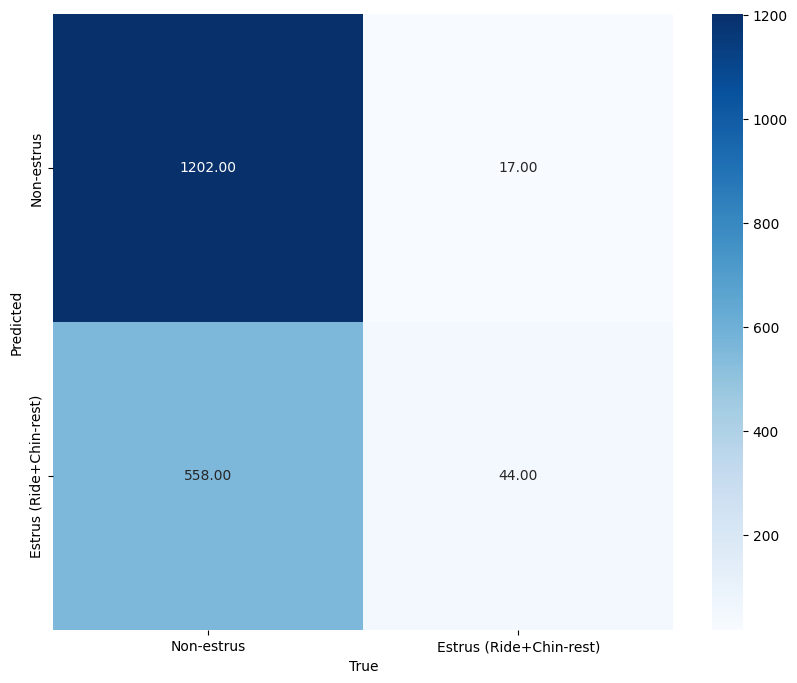

F1 Score Binary for top camera: 0.13273001508295626


In [42]:
#Confusion matrix of front camera
cm_binary = confusion_matrix(y_true_binary, y_pred_top_binary)  # Normalize by rows (true labels)
# Plot confusion matrix without normalization
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_binary.T,  # Transpose the confusion matrix to swap axes
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"],  # True on X-axis
    yticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"]   # Predicted on Y-axis
)

# Set labels and title
#plt.title('Confusion Matrix Top View')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

f1 = f1_score(y_true_binary, y_pred_top_binary,pos_label=1)
print(f'F1 Score Binary for top camera: {f1}')

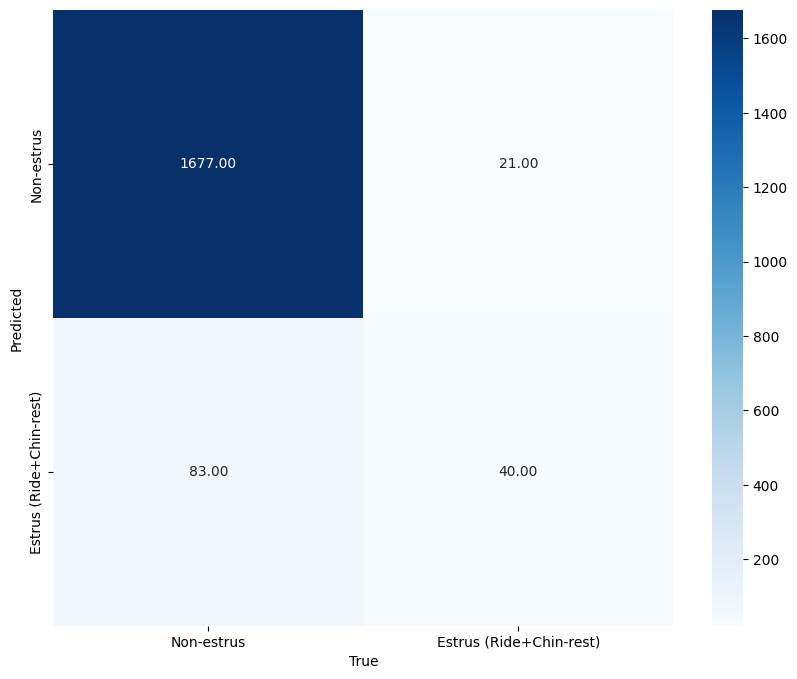

F1 Score Binary for front camera: 0.43478260869565216


In [45]:
#Confusion matrix of front camera
cm_binary = confusion_matrix(y_true_binary, y_pred_front_binary)  # Normalize by rows (true labels)
# Plot confusion matrix without normalization
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_binary.T,  # Transpose the confusion matrix to swap axes
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"],  # True on X-axis
    yticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"]   # Predicted on Y-axis
)

# Set labels and title
#plt.title('Confusion Matrix Top View')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

f1 = f1_score(y_true_binary, y_pred_front_binary,pos_label=1)
print(f'F1 Score Binary for front camera: {f1}')

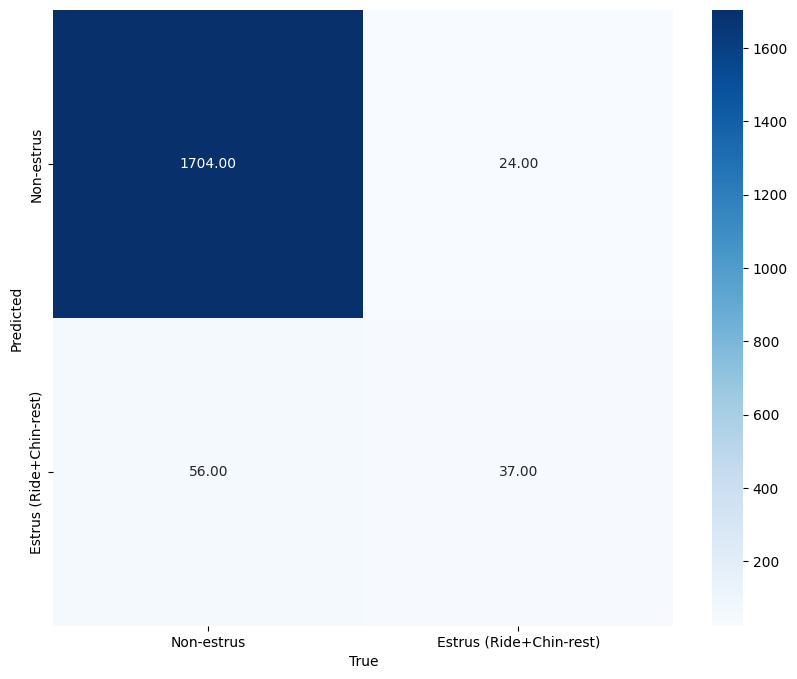

F1 Score Binary for ensemble method: 0.4805194805194805


In [44]:
#Confusion matrix of Ensemble method
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)  # Normalize by rows (true labels)
# Plot confusion matrix without normalization
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_binary.T,  # Transpose the confusion matrix to swap axes
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"],  # True on X-axis
    yticklabels=["Non-estrus","Estrus (Ride+Chin-rest)"]   # Predicted on Y-axis
)

# Set labels and title
#plt.title('Confusion Matrix Top View')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

f1 = f1_score(y_true_binary, y_pred_binary,pos_label=1)
print(f'F1 Score Binary for ensemble method: {f1}')